

### Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы:

- Произвести знакомство с данными и первичный анализ, подготовить данные для работы, при необходимости сменить тип;

- Разведочный анализ данных: детальное знакомство с данными,  поиск и обработка неочевидных пропусков, дубликатов, объединение таблиц;

- Исследовательский анализ данных: анализ распределения ежемесячных платежей, оказанных пользователям услуг, построение графиков (гистограммы, бокс плоты, столбчатые диаграммы). Анализ периода, в который абоненты прекращали обслуживание. Оценка количества пользователей в зависимости от даты регистрации договора. Поиск закономерностей и выдвежение гипотез.

- Подготовка признаков для обучения: исследование баланса классов, кодировка категориальных принаков, разделение на тренировочную и тестовую выборки;

- Обучение моделей: обучение моделей при помощи кросс-валидации, подбор гиперпараметров и их оценка ROC-AUC, accuracy;

- Сравнительный анализ моделей и поиск наилучшей;

- Общие выводы.

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import numpy as np

import time
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score
from catboost import Pool, CatBoostClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

## Импортируем данные.

In [110]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') 
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')    
    
except: 
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
    

## Изучим таблицы

### contract - информация о договоре

In [111]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [112]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Проверим дубликаты

In [113]:
contract.duplicated().sum()

0

In [114]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Посмотрим на уникальное количество пользователей.

In [115]:
len(contract['customerID'].unique())

7043

In [116]:
contract['TotalCharges'].isna().sum()

0

In [117]:
contract['TotalCharges'] = contract['TotalCharges'].replace([' '], 0)

In [118]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
#contract['EndDate'] = pd.to_datetime(contract['EndDate'], format= '%Y/%m/%d', errors='ignore')

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

In [119]:
x = contract['EndDate'] 
x = pd.to_datetime(x , format= '%Y/%m/%d', errors='coerce')

In [120]:
print (x.min())
print (x.max())

2019-10-01 00:00:00
2020-01-01 00:00:00


In [121]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [122]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Посмотрим на ежегодные платежи.

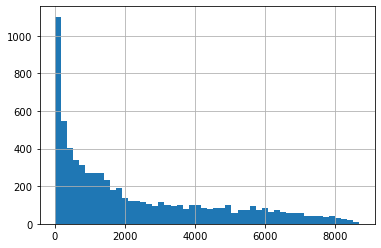

In [123]:
contract['TotalCharges'].hist(bins = 50)
plt.show()

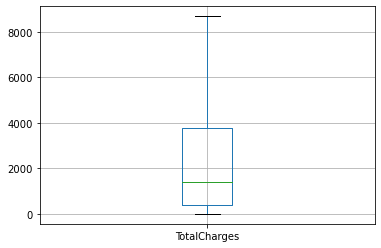

In [124]:
contract.boxplot('TotalCharges')
plt.show()

In [125]:
contract['TotalCharges'].describe() 

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

Видим скос в данных, высокое стандартное отклонение.

### Выводы по таблице contract

- Дубликатов нет

- В колонке customerID 7043 уникальных пользователей

- В BeginDate сменили формат на datetime

- PaperlessBilling можно в последствии перевести в булев тип, пока изменений не вносили.

- В разделе ежемесячных платежей MonthlyCharges нет выбросов, данные распределены нормально.

- Заменили пропуски на нули, чтобы привести к нужному типу float.

### internet информация об интернет-услугах

In [126]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [127]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [128]:
internet.duplicated().sum()

0

In [129]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [130]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

### Выводы по таблице internet

- количесво записей значительно меньше, чем в contract, возмжно не все пользователи подключили интернет.

- Пропусков и дубликатов нет

- Почти все типы записей бинарные.

### personal - персональные данные клиента

In [131]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [132]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [133]:
personal.duplicated().sum()

0

In [134]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Dependents?

### Выводы по таблице  personal

- Пропусков и дубликатов нет

- Почти все типы записей бинарные.

### phone - информация об услугах телефонии

In [135]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [136]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [137]:
phone.duplicated().sum()

0

In [138]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

### Выводы по таблице

- Явных пропусков и дубликатов нет. 
- Датафрейм содержит уникальный индификатор пользователя и бинарный признак MultipleLines 

### Общий вывод

- Мы рассмотрели 4 таблицы с данными: contract, internet, personal, phone.

- Общее количество клиентов - 7043 .

- Явных пропусков и дубликатов не обнаружили.

- EndDate – выделим как целевой признак.


In [139]:
personal['Partner'].value_counts() 

No     3641
Yes    3402
Name: Partner, dtype: int64

# 3 Предобработка и исследовательский анализ данных

## 3.1 Предобработка данных

### 3.1.1 Создание единого датасета

In [140]:
data = personal.merge(contract, on = 'customerID', how='outer')
data = data.merge(internet, on = 'customerID', how='outer')
data = data.merge(phone, on = 'customerID', how='outer')

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [142]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


### 3.1.2 Удаление неявных дубликатов и замена типов данных.

In [143]:
data.duplicated().sum()

0

In [144]:
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [145]:
data[data['InternetService'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
11,7469-LKBCI,Male,0,No,No,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,Female,0,No,No,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21,1680-VDCWW,Male,0,Yes,No,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,Male,0,No,No,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
33,7310-EGVHZ,Male,0,No,No,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,Female,0,No,No,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7019,9710-NJERN,Female,0,No,No,2016-11-01,No,Two year,No,Mailed check,20.15,826.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7020,9837-FWLCH,Male,0,Yes,Yes,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7030,0871-OPBXW,Female,0,No,No,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Пропуски в таблице появились в связи с тем, что некоторые абоненты не пользовались интернет услугами. Вместо пропусков поставим нули. 

In [146]:
data = data.fillna("No")

Для удобства сменим в 'EndDate' no на последнюю дату выгрузки '2020-02-01'. Дата будет означать, что клиент еще пользуется услугами компании.


In [147]:
data.loc[data['EndDate']== 'No', 'EndDate']= '2020-02-01'

In [148]:
data['EndDate'] = pd.to_datetime(data['EndDate'])

### 3.1.4 Добавление столбцов

Добавим столбец с количеством дней, через которое клиент ушел.

In [150]:
data['number_of_days'] = (data['EndDate'] - data['BeginDate']).dt.days

Добавим столбец с количеством дней от регистрации договора до даты сбора датасета - 2020-02-01.

Создадим столбец, в коротором присвоим ушедшим 1, оставшимся клиентам 0.

In [152]:
data['left'] = 0
data.loc[data['EndDate'] < '2020-02-01', 'left'] = 1
print (data['left'].value_counts())

0    5174
1    1869
Name: left, dtype: int64


In [153]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,number_of_days,left
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,No,No,No,No,No,61,1


### 3.2 Исследовательский анализ данных

#### План исследования:

 1. Анализ данных всех клиентов (до распределения на ушедших и оставшихся). 

Изучить портрет типичного клиента сервиса вне зависимости от того прекратил он обслуживание или нет. Изучить средние чеки и популярность предоставляемых услуг.
Вычислить средний срок пользования услугами.

 2. Разделить клиентов на ушедших и оставшихся.

По данным из таблицы personal

Найти зависимости по персональным данным клиентов.

По данным из таблицы contract:

- Вычислить средний ежемесячный платеж 

- Проверить в какой период прекращается обслуживание (в целом через какое время клиент с наибольшей вероятностью покидает компанию)

- Построить количество пользователей по дате регистрации и по дате окончания договора

- Проверить распределения типа и метода оплаты для ушедших клиентов


 По данным из таблицы internet

- Вычислить сколько пользователей каким типом интеренета пользуются и сколько из них ушедших

- Сколько ушедших клиентов пользовались доп.услугами


Проверить тип телефонной линии для ушедших и для постоянных клиентов.

### 1. Анализ данных всех клиентов

Исследуем личные данные.

In [154]:
data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

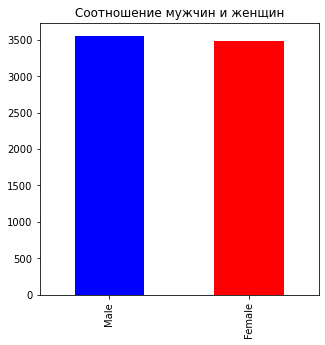

In [155]:
plt.figure(figsize=(5,5))
data['gender'].value_counts().plot.bar(color=('b', 'r'))
plt.title('Cоотношение мужчин и женщин')

plt.show()

In [156]:
data['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

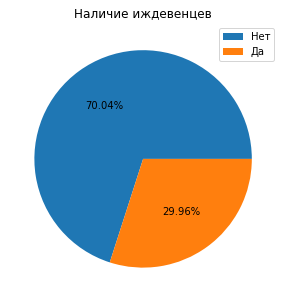

In [157]:
plt.figure(figsize=(5,5))
plt.pie(data['Dependents'].value_counts(),  autopct='%1.2f%%')
plt.legend(labels=('Нет', 'Да'))
plt.title('Наличие иждевенцев')
plt.show()

In [158]:
data['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

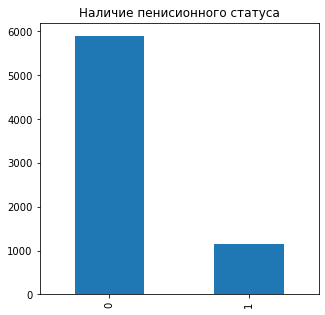

In [159]:
plt.figure(figsize=(5,5))
data['SeniorCitizen'].value_counts().plot.bar()
plt.title('Наличие пенисионного статуса')
plt.show()

In [160]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

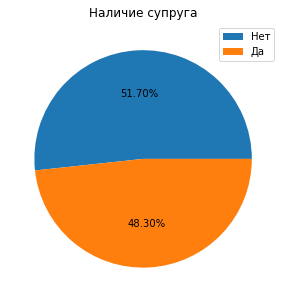

In [161]:
plt.figure(figsize=(5,5))
plt.pie(data['Partner'].value_counts(),  autopct='%1.2f%%')
plt.legend(labels=('Нет', 'Да'))
plt.title('Наличие супруга')
plt.show()

Выводы по личным данным всех абонентов:

- Среди клиентов оператора равное количество мужчин и женщин.

- 30% клиентов имеют детей

- Меньше четверти клиентов люди пенсионного возраста

- Около 50% клиенов находится в браке.

Посмотрим на даты заключения договоров.

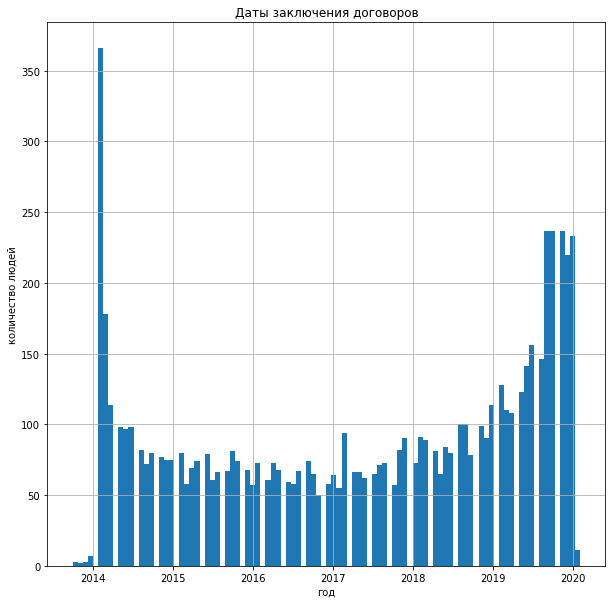

In [162]:
plt.figure(figsize = (10,10))
contract['BeginDate'].hist(bins=100)

plt.title('Даты заключения договоров')
plt.xlabel('год')
plt.ylabel('количество людей')
plt.show()

In [163]:
contract['BeginDate'].min()

Timestamp('2013-10-01 00:00:00')

У нас есть данные с 2013 по 2020 год. С 2014 по 2018 в среднем прибовлялось по 100 новых пользователей в месяц. С 2018 года виден плавный рост. Пик приходится на 2019-2020 годы.


Посмотрим через какое количество дей пользователи прекращают обслуживание. Оставим только ушедших пользователей.

In [164]:
x = data[data['EndDate'] < '2020-02-01']

In [165]:
#plt.figure(figsize= (15,5))
#sns.kdeplot(data=x['number_of_days'], multiple="stack")
#plt.title('Количество дней от регистрации до ухода')
#plt.show()

Получается, что большинство пользователей отменяют подписку в течении первых 300 дней, те 1 года.

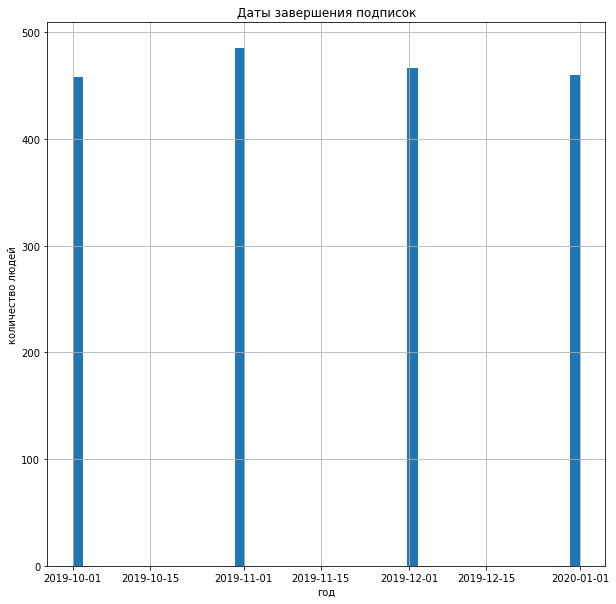

In [166]:
plt.figure(figsize = (10,10))
x['EndDate'].hist(bins = 50)
plt.title('Даты завершения подписок')
plt.xlabel('год')
plt.ylabel('количество людей')
plt.show()

Практически одинаковое количество людей завершили подписку 2019.10, 2019.11, 2019.12, 2020.01 те стабильно много людей отказывалось от услуг 4 месяца подряд.


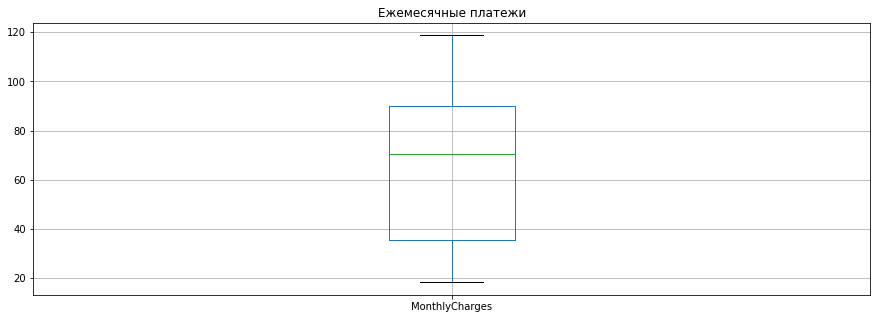

In [167]:
plt.figure(figsize= (15,5))
data.boxplot('MonthlyCharges')
plt.title('Ежемесячные платежи')
plt.show()

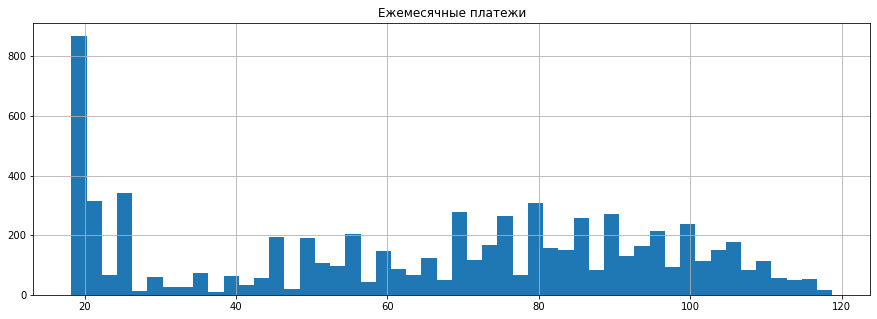

In [168]:
plt.figure(figsize= (15,5))
data['MonthlyCharges'].hist(bins = 50)
plt.title('Ежемесячные платежи')
plt.show()

In [169]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

В разделе ежемесячных платежей нет выбросов, данные распределены нормально. В среднем пользователи платят 64.7, максимальная оплата 118.7, минимальная 18.2.

Большинство пользователей прекратило подписку в конце 2019, что совпадает с периодом активного роста заключения новых договоров.

### 2. Анализ ушедших и оставшихся клиентов.

Сравним данные по оставшимся и ушедшим клиентам.


In [170]:
# таблица с ушедшими клиентами
client_left = data[data['left'] == 1]

# таблица с оставшимися
client_rest = data[data['left'] == 0]

Посмотрим различаются ли персональные данные ушедших и оставшихся абонентов.

<Figure size 360x360 with 0 Axes>

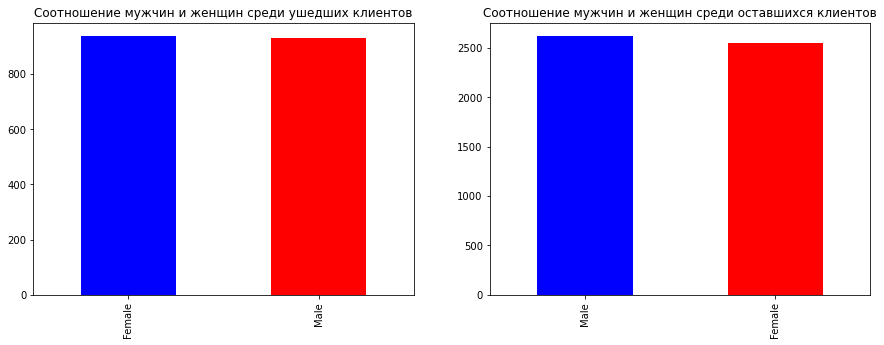

In [171]:
plt.figure(figsize=(5,5))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


client_left['gender'].value_counts().plot.bar(ax=axes[0], color=('b', 'r'))

axes[0].set_title('Cоотношение мужчин и женщин среди ушедших клиентов')

client_rest['gender'].value_counts().plot.bar(ax=axes[1], color=('b', 'r'))
axes[1].set_title('Cоотношение мужчин и женщин среди оставшихся клиентов')


plt.show()

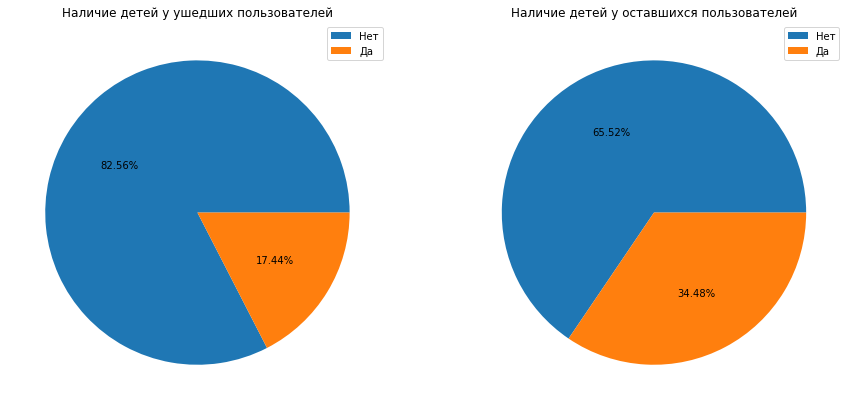

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.pie(client_left['Dependents'].value_counts(), autopct='%1.2f%%')
ax2.pie(client_rest['Dependents'].value_counts(), autopct='%1.2f%%')

ax1.set_title('Наличие детей у ушедших пользователей')
ax2.set_title('Наличие детей у оставшихся пользователей')

ax1.legend(labels=('Нет', 'Да'))
ax2.legend(labels=('Нет', 'Да'))

plt.show()

In [173]:
client_rest['SeniorCitizen'].value_counts()

0    4508
1     666
Name: SeniorCitizen, dtype: int64

In [174]:
client_left['SeniorCitizen'].value_counts()

0    1393
1     476
Name: SeniorCitizen, dtype: int64

<Figure size 360x360 with 0 Axes>

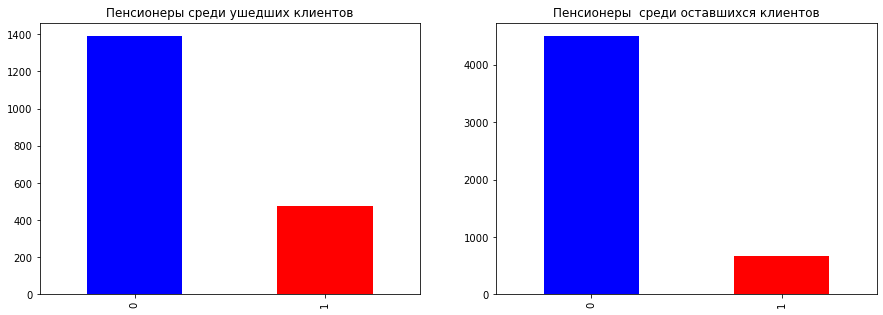

In [175]:
plt.figure(figsize=(5,5))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


client_left['SeniorCitizen'].value_counts().plot.bar(ax=axes[0], color=('b', 'r'))

axes[0].set_title('Пенсионеры среди ушедших клиентов')

client_rest['SeniorCitizen'].value_counts().plot.bar(ax=axes[1], color=('b', 'r'))
axes[1].set_title('Пенсионеры  среди оставшихся клиентов')


plt.show()

Выводы по личным данным клиентов:
- Среди ушедших и оставшихсяклиенов равное количество мужчини женщин.

- У 34% процентов оставшихся пользоватей и у 18% ушедших есть дети.

- Людей пенсионного возраста немного больше среди оставшихся абонентов  666 против 476.

Посмотрим на платежи.

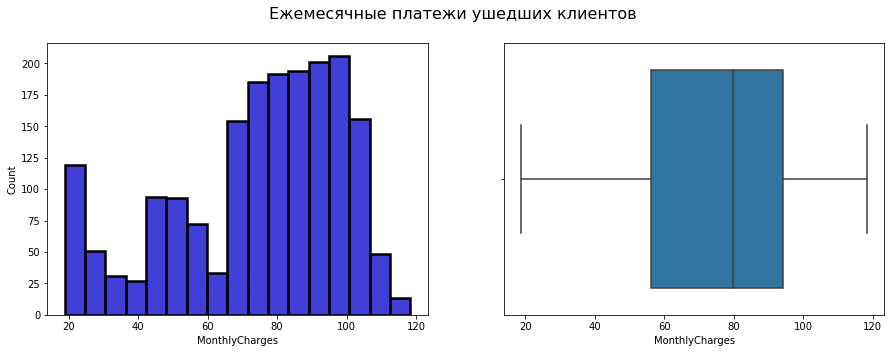

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
fig.suptitle('Ежемесячные платежи ушедших клиентов', fontsize=16)
       
sns.histplot(ax=axes[0], data=client_left, x = 'MonthlyCharges', color='mediumblue', linewidth=2.5)
sns.boxplot(ax=axes[1], x=client_left['MonthlyCharges'])

plt.show()

In [177]:
client_left['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [178]:
client_left['MonthlyCharges'].median()

79.65

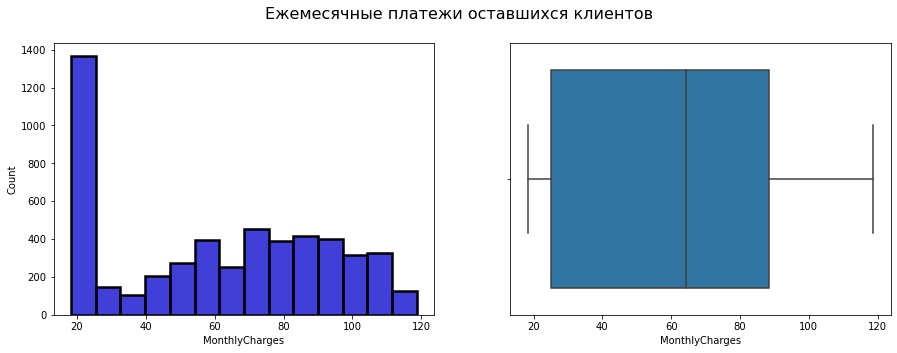

In [179]:
fig, axes = plt.subplots(1, 2,figsize=(15, 5))
    
fig.suptitle('Ежемесячные платежи оставшихся клиентов', fontsize=16)
       
sns.histplot(ax=axes[0], data=client_rest, x = 'MonthlyCharges', color='mediumblue', linewidth=2.5)
sns.boxplot(ax=axes[1], x=client_rest['MonthlyCharges'])
        
plt.show()

In [180]:
client_rest['MonthlyCharges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [181]:
client_rest['MonthlyCharges'].median()

64.42500000000001

Видим, что ежемесячный платеж клиентов, которые остались меньше, чем у ушедших. 

У оставшихся:

- Медианная сумма платежа - 64.4

- Большинство людей платят от 25 до 88. Данные немного скошены влево.

У ушедших:

- Медианная сумма платежа - 79.65

- Большинство людей платят от 56 до 94. Данные немного скошены вправо

In [182]:
client_rest['TotalCharges']

0         29.85
1       1889.50
3       1840.75
6       1949.40
7        301.90
         ...   
7037    1419.40
7038    1990.50
7039    7362.90
7040     346.45
7042    6844.50
Name: TotalCharges, Length: 5174, dtype: float64

Пик распределения общих платежей значительно выше у ушедших, чем у оставшихся.

Посморим какими услугами пользуются клиенты.

In [184]:
client_rest[['InternetService']].value_counts()

InternetService
DSL                1962
Fiber optic        1799
No                 1413
dtype: int64

<Figure size 360x360 with 0 Axes>

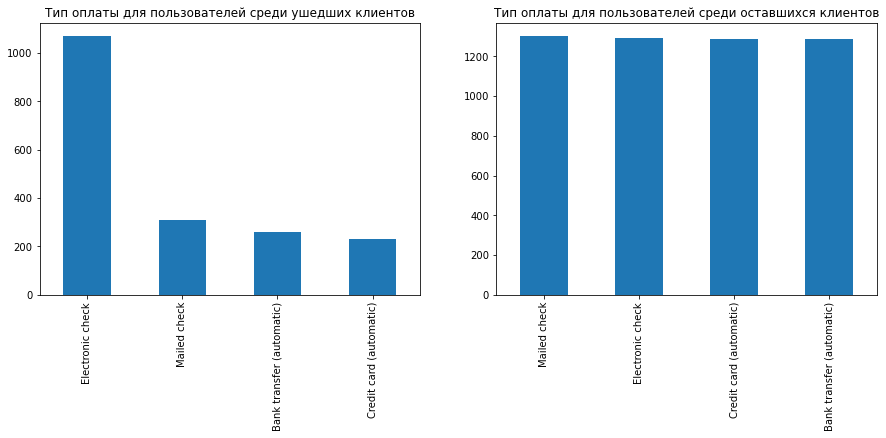

In [185]:
plt.figure(figsize=(5,5))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


client_left['PaymentMethod'].value_counts().plot.bar(ax=axes[0])

axes[0].set_title('Тип оплаты для пользователей среди ушедших клиентов', fontsize = 12)

client_rest['PaymentMethod'].value_counts().plot.bar(ax=axes[1])
axes[1].set_title('Тип оплаты для пользователей среди оставшихся клиентов', fontsize = 12)


plt.show()
    

Клиенты, которые остались пользуются всеми типами платежей одинаково. Ушедшие клиенты отавали предпочтение оплате по электронным чекам. 

Сравним виды интернет услугабонентов.

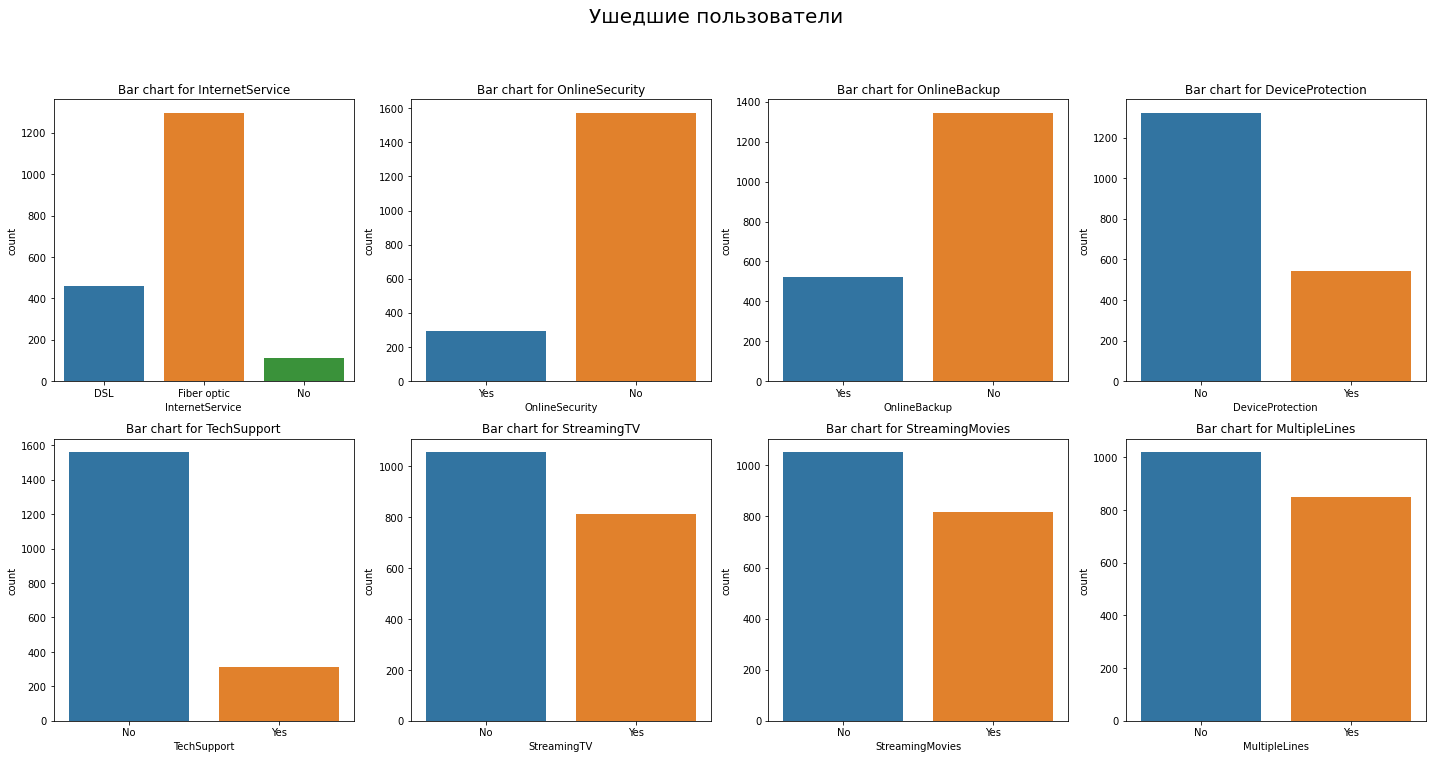

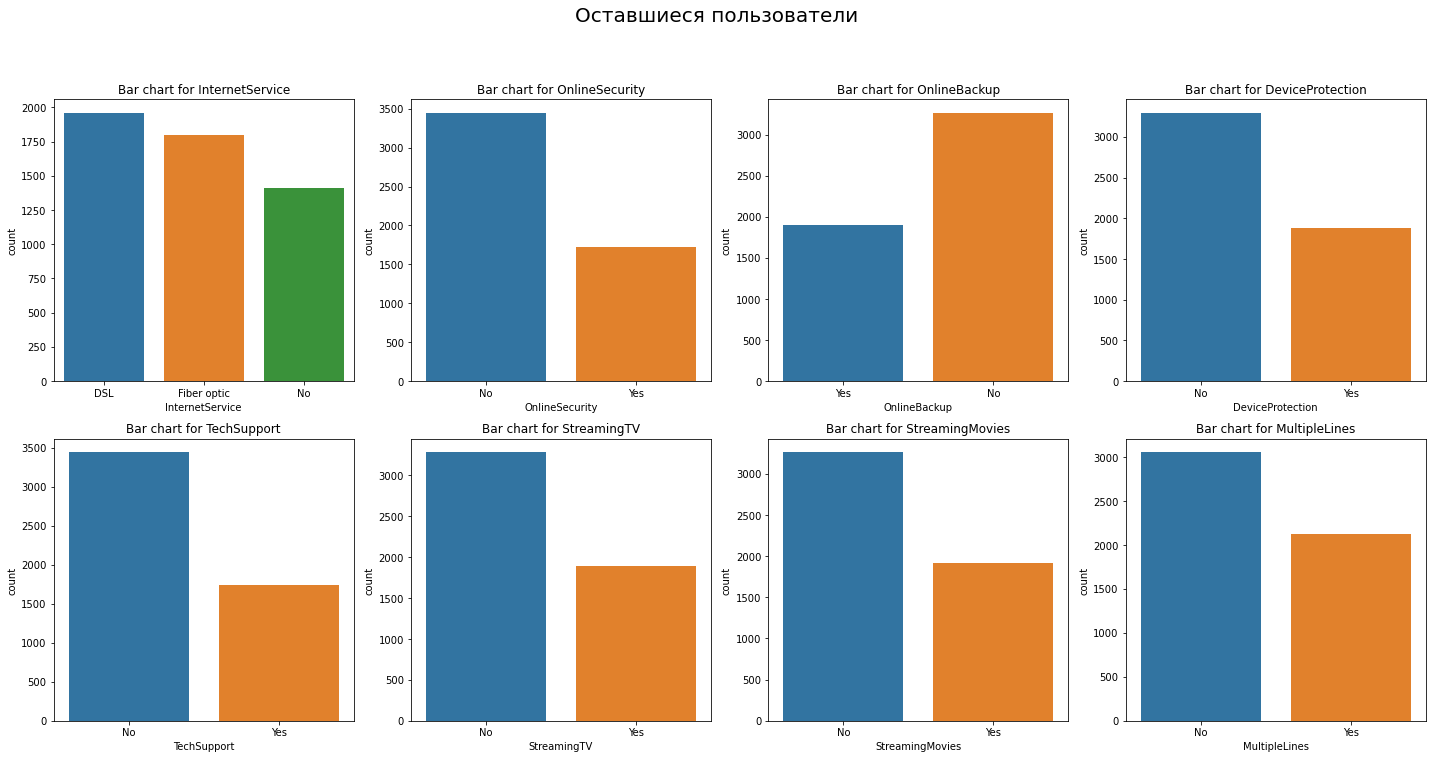

In [186]:
col_names = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, column_name in enumerate(col_names):
    sns.countplot(x=column_name, data=client_left, ax=ax.flat[i])
    ax.flat[i].set_title(f"Bar chart for {column_name}")

plt.suptitle('Ушедшие пользователи', fontsize=20, y=1.05)
plt.tight_layout()

plt.show()


col_names = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, column_name in enumerate(col_names):
    sns.countplot(x=column_name, data=client_rest, ax=ax.flat[i])
    ax.flat[i].set_title(f"Bar chart for {column_name}")

plt.suptitle('Оставшиеся пользователи', fontsize=20, y=1.05)
plt.tight_layout()

plt.show()

Ушедшие абоненты:

В основном пользовались оптоволоконным интернет соединением, стримминговыми сервисами,  50 % пользовались возмножностью ведения паралелльных линий во время звонка. Остальные виды услуг были непопулярны. 

Оставшиеся:

Пользуются в одинаковой мере DSL и оптоволоконным интернет соединением. Остальные признаки равнораспределены по выборке.


Посмотрим на предпочтительный вид договора.

In [187]:
client_left['Type'].value_counts()

Month-to-month    1655
One year           166
Two year            48
Name: Type, dtype: int64

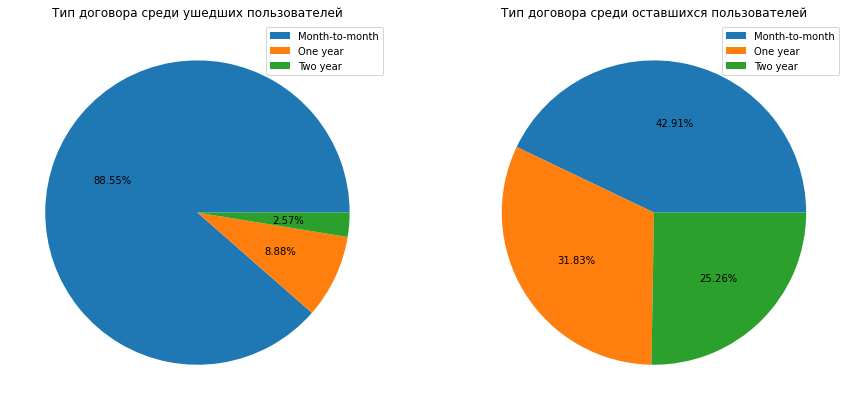

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.pie(client_left['Type'].value_counts(), autopct='%1.2f%%')
ax2.pie(client_rest['Type'].value_counts(), autopct='%1.2f%%')

ax1.set_title('Тип договора среди ушедших пользователей')
ax2.set_title('Тип договора среди оставшихся пользователей')

ax1.legend(labels=('Month-to-month', 'One year', 'Two year'))
ax2.legend(labels=('Month-to-month', 'One year', 'Two year'))

plt.show()

Тип оплаты month-to-month использлвали 88.5% ушедших клиентов. Среди оставшихся month-to-month-42.9%, one year - 31.8,  two year  - 25.3.

Корреляция признаков

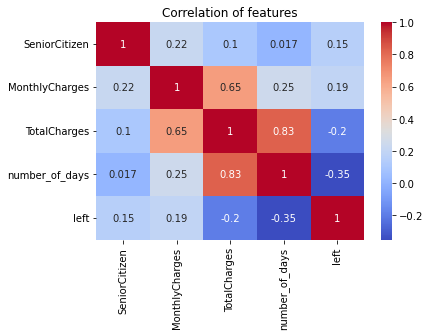

In [189]:
corr = data.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation of features")

# Show the plot
plt.show()

Выводы по исследовательскому анализу данных.

- Среди ушедших и оставшихсяклиенов равное количество мужчини женщин.

- У 34% процентов оставшихся пользоватей и у 18% ушедших есть дети.

- Людей пенсионного возраста немного больше среди оставшихся абонентов  666 против 476.

- Большинство пользователей уходят до года пользования услугами - около 304 дней.

У оставшихся: Медианная сумма платежа - 64.4. Большинство людей платят от 25 до 88. Данные немного скошены влево.

У ушедших: Медианная сумма платежа - 79.65. Большинство людей платят от 56 до 94. Данные немного скошены вправо


- Уходить пользователи стали с конца 2019 года, или их уход не фиксировался.

- 55% всех пользователей используют оплату month-to-month.

- Тип оплаты month-to-month использлвали 88.5% ушедших клиентов. Среди оставшихся month-to-month-42.9%, one year - 31.8,  two year  - 25.3.

- Среди ушедших клиентов только 12% использовали тип оплаты one year или two year.

- Оставшиеся пользователи в равной степени используют все 4 метода оплаты.

- Ушедшие абоненты: В основном пользовались оптоволоконным интернет соединением, стримминговыми сервисами, 50 % пользовались возмножностью ведения паралелльных линий во время звонка. Остальные виды услуг были непопулярны.

- Оставшиеся: Пользуются в одинаковой мере DSL и оптоволоконным интернет соединением. Остальные признаки равнораспределены по выборке.

- Целевой признак 'left'.

## 4 Обучение модели

4.1 Подготовка признаков

4.1.1 Разбиение на трейн и тест

4.2 Баланс классов и масштаб признаков

#### 4.1 Подготовка признаков

Подготовим признаки, обучающую и тестовую выборку.

Столбец 'customerID', является утечкой целевого признака

Так же, удалим несколько столбцов с информацией об услугах, так как они взаимосвязаны с ежемесячным платежом и суммой общих расходов.

Целевой признак - left

Создадим признаки и таргет.

In [191]:
features = data.drop(['TotalCharges','customerID','left', 'BeginDate', 'EndDate',
                          'MultipleLines', 'PaperlessBilling', 'DeviceProtection',
                         'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                          'Dependents', 'gender'], axis = 1)
target = data['left']

In [192]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state = 300123, stratify=target)


print (features_train.shape)
print (target_train.shape)

print(features_test.shape)
print (target_test.shape)

(5282, 10)
(5282,)
(1761, 10)
(1761,)


Проверим признаки на баланс классов.

In [193]:
target_train.value_counts()

0    3880
1    1402
Name: left, dtype: int64

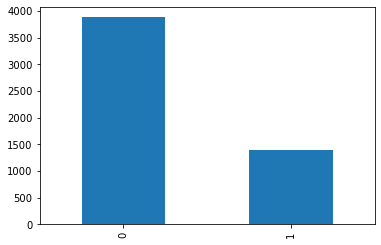

In [194]:
target_train.value_counts().plot.bar()
plt.show()

Видим дисбаланс, будем использовать class_weight = 'balanced'.

In [195]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 517 to 6997
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SeniorCitizen    5282 non-null   int64  
 1   Partner          5282 non-null   object 
 2   Type             5282 non-null   object 
 3   PaymentMethod    5282 non-null   object 
 4   MonthlyCharges   5282 non-null   float64
 5   InternetService  5282 non-null   object 
 6   TechSupport      5282 non-null   object 
 7   StreamingTV      5282 non-null   object 
 8   StreamingMovies  5282 non-null   object 
 9   number_of_days   5282 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 453.9+ KB


In [196]:
#категориальные признаки для OHE 
ohe_features_rf = features_train.select_dtypes(include='object').columns.to_list()

In [197]:
ohe_features_rf

['Partner',
 'Type',
 'PaymentMethod',
 'InternetService',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [198]:
#численные признаки

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
num_features

['MonthlyCharges', 'number_of_days']

###### Обучим RandomForesClassifier.

In [199]:
%%time

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(random_state=300123, class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
     'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}

#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=300123
)

gs_rf.fit(features_train, target_train)

gs_rf_best_score = gs_rf.best_score_ 
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')


best_score: 0.8537832925618059
best_params: {'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 9}
CPU times: total: 1.38 s
Wall time: 14.6 s


###### Обучим LGBMClassifier

In [200]:
%%time

col_transformer_model_LGBM= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_LGBM = LGBMClassifier(random_state=300123, class_weight='balanced')

pipline_LGBM = make_pipeline(col_transformer_model_LGBM, model_LGBM)

param_grid_LGBM = {'lgbmclassifier__learning_rate':[0.5, 0.1, 0.01],
                'lgbmclassifier__num_leaves':[10, 15, 20], 
               'lgbmclassifier__max_depth': [20, 30, 60]
     
}

#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_LGBM = RandomizedSearchCV(
    pipline_LGBM, 
    param_distributions=param_grid_LGBM, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=300123
)

gs_LGBM.fit(features_train, target_train)
gs_LGBM_best_score = gs_LGBM.best_score_ 

gs_LGBM_best_params = gs_LGBM.best_params_
print(f'best_score: {gs_LGBM_best_score}')
print(f'best_params: {gs_LGBM_best_params}')

best_score: 0.9066803301511014
best_params: {'lgbmclassifier__num_leaves': 10, 'lgbmclassifier__max_depth': 60, 'lgbmclassifier__learning_rate': 0.5}
CPU times: total: 562 ms
Wall time: 3.94 s


###### Обучим CatBoostClassifier

In [201]:
%%time

col_transformer_model_cat = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features_rf),
    
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_cat= CatBoostClassifier(random_state=300123)

pipline_cat = make_pipeline(col_transformer_model_cat, model_cat)

param_grid_cat = {'catboostclassifier__learning_rate':[0.5, 0.03],
                'catboostclassifier__depth':[10, 3],                
                'catboostclassifier__verbose':[False]}




#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_cat = RandomizedSearchCV(
    pipline_cat, 
    param_distributions=param_grid_cat, 
    scoring='roc_auc', 
    n_jobs=-1, 
   
)

gs_cat.fit(features_train, target_train)


gs_cat_best_estimator = gs_cat.best_estimator_ 
gs_cat_best_score = gs_cat.best_score_ 
gs_cat_best_params = gs_cat.best_params_
print(f'best_score: {gs_cat_best_score}')
print(f'best_params: {gs_cat_best_params}')


C:\Users\Daria\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best_score: 0.9214021054224603
best_params: {'catboostclassifier__verbose': False, 'catboostclassifier__learning_rate': 0.5, 'catboostclassifier__depth': 3}
CPU times: total: 7.94 s
Wall time: 2min 7s


#### Сравнение моделей

In [202]:
result = pd.DataFrame(
    [gs_cat_best_score, gs_LGBM_best_score, gs_rf_best_score], 
    index=['Catboost', 'LGBM', 'Randomforest'], 
    columns=['ROC-AUC']
)

result

,ROC-AUC
Catboost,0.921402
LGBM,0.906680
Randomforest,0.853783


Наилучшие результаты показала модель CatBoostClassifier

#### Проверим CatBoostClassifier на тестовой выборке

In [203]:
cat_prediction = gs_cat.predict(features_test)

cat_Prediction_Proba = gs_cat.predict_proba(features_test)[:,1]
metric_test_cat = roc_auc_score(target_test, cat_Prediction_Proba)
cat_accuracy = accuracy_score(target_test, cat_prediction)


print ("ROC-AUC Catboost:",  metric_test_cat)
print ("Accuracy Catboost:", cat_accuracy)

ROC-AUC Catboost: 0.9352149105242777
Accuracy Catboost: 0.8898353208404316


Catboost: ROC AUC=0.935


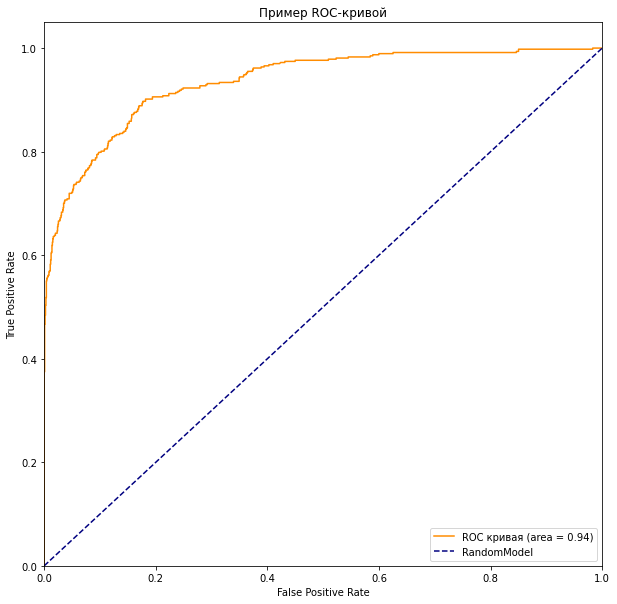

In [204]:
# сохраняем вероятности только для положительного исхода
cat_probs = cat_Prediction_Proba
# рассчитываем ROC AUC
cat_auc = roc_auc_score(target_test, cat_probs)
print('Catboost: ROC AUC=%.3f' % (cat_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, cat_probs)
roc_auc = auc(fpr, tpr)
# строим график

plt.figure(figsize = (10,10))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='RandomModel')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Text(33.0, 0.5, 'Истинный класс')

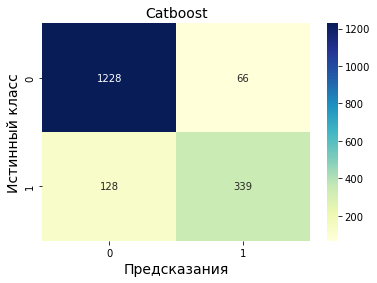

In [205]:

heatmap_1 = sns.heatmap((confusion_matrix(target_test, cat_prediction)), 
                            cmap="YlGnBu", 
                            annot=True, fmt='d')
    
heatmap_1.set_title("Catboost", fontdict={'fontsize':14})
heatmap_1.set_xlabel('Предсказания', fontsize=14)
heatmap_1.set_ylabel('Истинный класс', fontsize=14)

In [206]:
best_catboost_model = gs_cat.best_estimator_.named_steps['catboostclassifier']

importances = best_catboost_model.feature_importances_
col_transformer = gs_cat.best_estimator_.named_steps['columntransformer']
onehot_encoder = col_transformer.transformers_[0][1]
ohe_feature_names = onehot_encoder.get_feature_names(input_features=ohe_features_rf)

feature_names = np.concatenate([ohe_feature_names, num_features])
feature_names = np.append(feature_names, 'SeniorCitizen')

feature_importances = pd.DataFrame(data={'feature_name': feature_names, 'importance': importances})
display(feature_importances.sort_values(by= 'importance', ascending=False))

C:\Users\Daria\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature_name,importance
12,number_of_days,61.785848
11,MonthlyCharges,21.178958
2,Type_Two year,4.291724
6,InternetService_Fiber optic,2.351862
5,PaymentMethod_Mailed check,1.505553
1,Type_One year,1.504880
4,PaymentMethod_Electronic check,1.493101
13,SeniorCitizen,1.193455
0,Partner_Yes,1.110695
10,StreamingMovies_Yes,1.015419


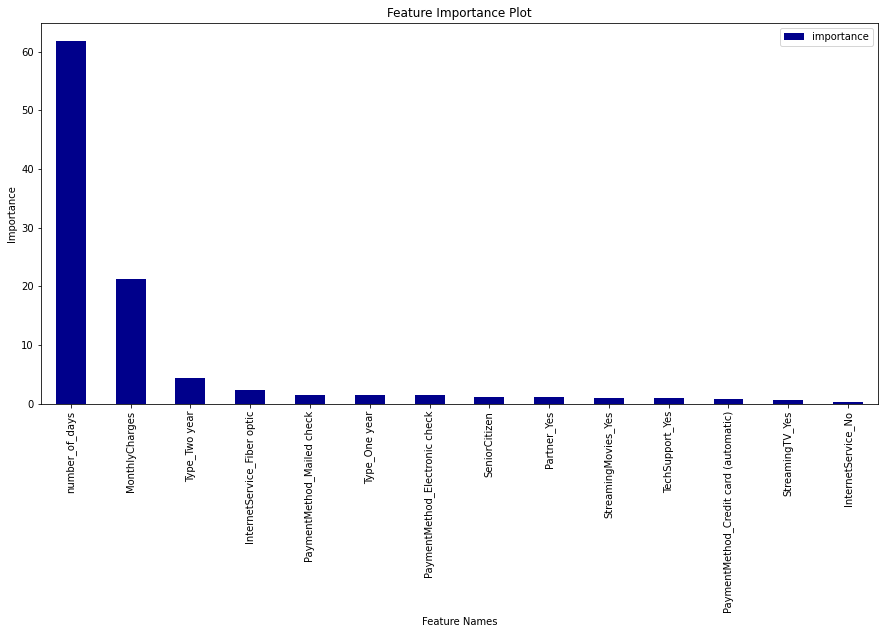

In [207]:
feature_importances.sort_values(by= 'importance', ascending=False).plot(x='feature_name', y='importance', kind='bar', figsize=(15,7), color='darkblue')
plt.title('Feature Importance Plot')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

Наиболее важными признаками для модели оказались длительность контракта и ежемесячные выплаты. Далее по важности - вид заключенного договора и наличие оптоволоконного интернета. Наименее значимые - стриминговые сервисы.

### Выводы

На этапе обучения моделей было обучено 3 модели: Randomforest, LGBM, Catboost.

Наилучшие результаты дала модель CatboostClassifier с гиперпараметрами: iterations =1000, learning_rate= 0.5,  max_depth=3, random_state = 270123, loss_function= 'CrossEntropy') 

Наилучшие метрики:
ROC-AUC Catboost: 0.93

Accuracy Catboost: 0.88

## ОТЧЕТ

### Цель проекта

Целью проекта было создать модель, которая на основе поведения пользователя будет предсказывать уход клиента из компании. В качестве целевой метрики была выбрана AUC-ROC, таже принималось во внимание качество метрики accuracy, определяющая точность предсказаний модели.

### Описание услуг
Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных
Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;
personal.csv — персональные данные клиента;
internet.csv — информация об интернет-услугах;
phone.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


В качестве сырых данных были 4 таблицы с различной информацией о клиентах оператора. 
personal - таблица с персональными данными клиентов, contract— информация о договоре, internet — информация об интернет-услугах, phone — информация об услугах телефонии.



#### На этапе загрузки и знакомств с данными:

- Мы рассмотрели 4 таблицы с данными: contract, internet, personal, phone.

- Общее количество клиентов - 7043 .

- Явных пропусков и дубликатов не обнаружили.

- EndDate – выделили как целевой признак.

- После объединения таблиц появились пропущенные значения, так как не все клиенты пользовались услугами интернета/телефона. Из данных по таблице internet - 1526 шт, и 682 пропуска для столбца телефонии. Все они были обработаны на подходящие значения.

#### После первичного ознакомления с данными был намечен следующий план работы:

- Произвести разведочный анализ данных: детальное знакомство с данными, поиск и обработка неочевидных пропусков, дубликатов, объединение таблиц;

- Исследовательский анализ данных: анализ распределения ежемесячных платежей, оказанных пользователям услуг, построение графиков (гистограммы, бокс плоты, столбчатые диаграммы). Анализ периода, в который абоненты прекращали обслуживание. Оценка количества пользователей в зависимости от даты регистрации договора. Поиск закономерностей и выдвежение гипотез.

- Подготовка признаков для обучения: исследование баланса классов, кодировка категориальных принаков, разделение на тренировочную и тестовую выборки;

- Обучение моделей: обучение моделей при помощи кросс-валидации, подбор гиперпараметров и их оценка ROC-AUC, accuracy;

- Сравнительный анализ моделей и поиск наилучшей;

- Общие выводы.

####  На этапе предобработки данных:

- Данные были объединены в одну таблицу, проанализированы и заполнены пропуски. 

- Дубликатов не выявлено, все записи уникальные.

- Добавлен столбец с количеством дней, через которое клиент ушел.

- Добавлен столбец с количеством дней от регистрации договора до даты сбора датасета - 2020-02-01.

- Создан столбец с целевым признаком "left", в котором присвоили ушедшим 1, оставшимся клиентам 0.


#### Выводы по исследовательскому анализу данных.

Проанализировав общие данные о всех пользователях, были сделаны следующие выводы:

В разделе ежемесячных платежей нет выбросов, данные распределены нормально. В среднем пользователи платят 64.7, максимальная оплата 118.7, минимальная 18.2.

Большинство пользователей прекратило подписку в конце 2019, что совпадает с периодом активного роста заключения новых договоров.

После разбиения пользователей на ушедших и оставшихся:


- Среди ушедших и оставшихся клиентов равное количество мужчин и женщин.

- У 34% процентов оставшихся пользователей и у 18% ушедших есть дети.

- Людей пенсионного возраста немного больше среди оставшихся абонентов  666 против 476.

- Большинство пользователей уходят до года пользования услугами - около 304 дней.

- У оставшихся: Медианная сумма платежа - 64.4. Большинство людей платят от 25 до 88. Данные немного скошены влево.

- У ушедших: Медианная сумма платежа - 79.65. Большинство людей платят от 56 до 94. Данные немного скошены вправо

- Уходить пользователи стали с конца 2019 года, или их уход не фиксировался.

- 55% всех пользователей используют оплату month-to-month.

- Тип оплаты month-to-month использовали 88.5% ушедших клиентов. Среди оставшихся month-to-month-42.9%, one year - 31.8,  two year  - 25.3.

- Среди ушедших клиентов только 12% использовали тип оплаты one year или two year.

- Оставшиеся пользователи в равной степени используют все 4 метода оплаты.

- Ушедшие абоненты: В основном пользовались оптоволоконным интернет соединением, стриминговыми сервисами, 50 % пользовались возможностью ведения параллельных линий во время звонка. Остальные виды услуг были непопулярны.

- Оставшиеся: Пользуются в одинаковой мере DSL и оптоволоконным интернет соединением. Остальные признаки равно распределены по выборке.

- Целевой признак 'left'.

####  На этапе обучения моделей:

1. Были отобраны следующие признаки: 

 1   Partner - находится ли в браке       
 
 2   Type - тип заключенного договора     
 
 3   PaymentMethod - вид оплаты    
 
 4   MonthlyCharges - сумма ежемесячных платежей
 
 5   InternetService  - пользуется ли абонент интернет услугами
 
 6   TechSupport - тех поддержка   
 
 7   StreamingTV - пользуется ли абонент стриминговым телевидением  
 
 8   StreamingMovies - смотрит ли абонент стриминговыми видеосервисами  
 
 9   number_of_days - количество дней от регистрации пользователя до завершения обслуживания.
 
 10 SeniorCitizen - имеет ли абонент пенсионное удостоверение.
 
 
2. Данные были разбиты на тренировочную и тестовую выборку в  отношении 75/25. Обучение моделей проводилось на кросс-валидации, поэтому отдельно валидационную выборку не создавали. 
При изучении целевого признака был замечен дисбаланс классов в отношении 1:3. Было принято решение передавать моделям наименьший вес класса как приоритетный.

3. Для кодировки признаков были применены:
standart scaler -  для масштабирования численных признаков - 'MonthlyCharges', 'number_of_days'
one hot encoder - для перевода категориальных признаков в численные -   'Partner', 'Type', 'PaymentMethod', 'InternetService', 'TechSupport', 'StreamingTV', 'StreamingMovies'.

4. С помощью подборщика параметров и кросс валидатора RandomizedSearchCV были отобраны и обучены 3 модели. 

##### 1. RandomForesClassifier

Наилучшими гиперпараметрами стали: 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 9.

Наилучшей метрикой на тренировочный выборке: 0.8537832925618059

##### 2. LGBMClassifier
Наилучшими гиперпараметрами стали:'lgbmclassifier__num_leaves': 10, 'lgbmclassifier__max_depth': 60, 'lgbmclassifier__learning_rate': 0.5

Наилучшей метрикой на тренировочный выборке: 0.90

##### 3. CatBoostClassifier

Наилучшими гиперпараметрами стали: 'catboostclassifier__verbose': False, 'catboostclassifier__learning_rate': 0.5, 'catboostclassifier__depth': 3

Наилучшей метрикой на тренировочный выборке: 0.92

#### Тестирование модели
Наилучшую метрику выдала модель  CatBoostClassifier, протестировали ее на тестовой выборке.
Получили следующие метрики:

ROC-AUC Catboost: 0.93
Accuracy Catboost: 0.88

Наиболее важными признаками для модели оказались длительность контракта и ежемесячные выплаты. Далее по важности - вид заключенного договора и наличие оптоволоконного интернета. Наименее значимые - стриминговые сервисы.





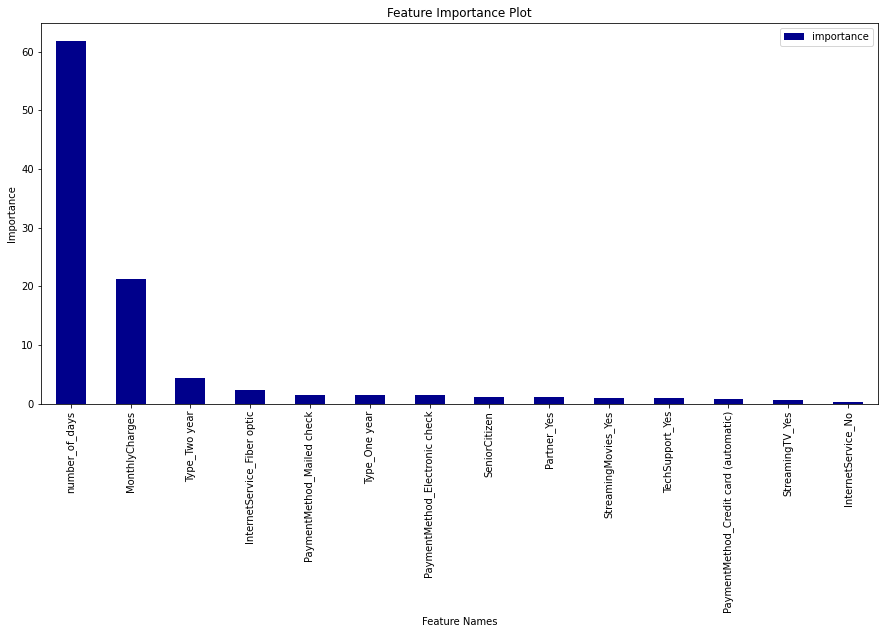

In [208]:
feature_importances.sort_values(by= 'importance', ascending=False).plot(x='feature_name', y='importance', kind='bar', figsize=(15,7), color='darkblue')
plt.title('Feature Importance Plot')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

Данные по матрице ошибок:

Text(33.0, 0.5, 'Истинный класс')

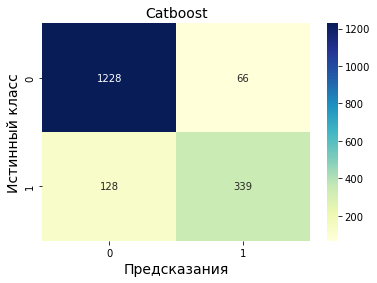

In [209]:
heatmap_1 = sns.heatmap((confusion_matrix(target_test, cat_prediction)), 
                            cmap="YlGnBu", 
                            annot=True, fmt='d')
    
heatmap_1.set_title("Catboost", fontdict={'fontsize':14})
heatmap_1.set_xlabel('Предсказания', fontsize=14)
heatmap_1.set_ylabel('Истинный класс', fontsize=14)

Означают, что модель в 339 случаях правильно распознала ушедших клиентов, в 1228 случаях правильно распознала оставшихся. Ошиблась модель, распознав оставшихся клиентов как ушедших всего 66 раз. То есть здесь возможна утечка бюджета и предложение дополнительных акций/ скидок людям, абонентам, которые не собирались уходить.  Также в 128 случаях модель не распознала уходящих клиентов, идентифицировав их как оставшихся.

Предсказания модели лучше, чем Дамми-модель.

Какие пункты плана были выполнены, а какие — нет (поясните почему)?
Какие трудности возникли и как вы их преодолели?

#### Трудности возникшие в ходе реализации проекта:

Затруднение вызвал отбор подходящих признаков для обучения модели. Необходимо было убрать ряд признаков, способствовавших утечке данных и переобучении модели, а также ряд неинформативных признаков, приводивших к шуму в данных и падение метрики.

#### Какие пункты плана были выполнены, а какие — нет.

Все пункты намеченного пана были реализованы. Однако можно было бы провести более глубокое исследование и выяснить подорожание каких конкретно услуг стало отпугивать пользователей. Для этого было бы необходимо посмотреть на размеры потребляемых пользователями услуг (объем трафика, количество израсходованных минут), иметь более четкое представление о предлагаемых тарифах и пакетах данных. Возможно, решением проблемы стало бы не предложение сидки/ промокода, а формирование нового тарифного плана, более подходящего ушедшим пользователям. Данная задача выходила за рамки нашего проекта, однако возможность анализа в этом направлении необходимо учитывать.